In [2]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from tqdm import tqdm
import tensorflow as tf
import keras
import numpy as np
import cv2
import seaborn as sns
import random
from PIL import Image
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception,VGG16,ResNet50
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from numpy.random import seed

# Pre-processing Image

In [3]:
# Reading the data
path = '../input/skin-cancer-mnist-ham10000/'
images_path = {os.path.splitext(os.path.basename(x))[0]:x for x in glob.glob(os.path.join(path,'*','*.jpg'))}

In [4]:
# Encoding target values
lesion_type_dict = {
    'nv':'Melanocytic Nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
    
}

In [5]:
# Reading Metadata csv file
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [6]:
# Adding extra columns and appending the required created columns in final dataframe
skin_df['path'] = skin_df['image_id'].map(images_path.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get)
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [7]:
# Checking the dataframe info.
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            9958 non-null   float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


In [8]:
# Image Reading and Resizing.
IMAGE_SIZE = 71
def read_img(img_path):
  img = cv2.imread(img_path,cv2.IMREAD_COLOR)
  img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # convert BGR to RGB
  return img
train_img = []
for img_name in tqdm(skin_df['path'].values):
  train_img.append(read_img(img_name))

100%|██████████| 10015/10015 [02:28<00:00, 67.30it/s]


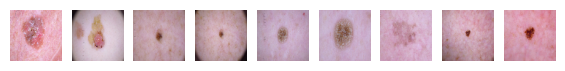

In [9]:
#Visulaizing the images
plt.figure(figsize=(15,12))
for i in range(9,18,1):
    plt.subplot(9,19,i)
    plt.imshow(train_img[i])
    plt.axis('off')
plt.show()

In [10]:
# Converting it into float arrays and normalizing it
X = np.array(train_img,np.float32)/255
print(X.shape)

(10015, 71, 71, 3)


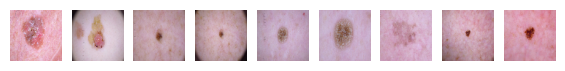

In [11]:
#Visulaizing the normalized images
plt.figure(figsize=(15,12))
for i in range(9,18,1):
    plt.subplot(9,19,i)
    plt.imshow(X[i])
    plt.axis('off')
plt.show()

In [12]:
# Creating Target
y = np.array(skin_df['cell_type_idx'])

In [13]:
# Splitting the data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=28,stratify=y)
x_train,x_val,y_train,y_val =   train_test_split(x_train,y_train,test_size=0.10,random_state=28,stratify=y_train)

In [14]:
# One-Hot Encoding values
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes = 7)
y_val = to_categorical(y_val , num_classes=7)

# Creating CNN Model

In [15]:
# Defining base model using Xception module from Keras
training_shape = (71,71,3)
base_model = Xception(include_top=False,weights='imagenet',input_shape = training_shape)
for layer in base_model.layers:
    layer.trainable = True                         # Training all layers from scratch

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [16]:
#Adding layers at end
n_classes = 7
model = base_model.output
model = Flatten()(model)
model = Dense(128)(model)
model = Dropout(0.5)(model)
model = BatchNormalization()(model)
model = Activation('relu')(model)
output = Dense(n_classes, activation='softmax')(model)
model = Model(inputs=base_model.input, outputs=output)

In [17]:
# Compiling the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [18]:
# Model Summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 71, 71, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 35, 35, 32)     │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 35, 35, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 35, 35, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 33, 33, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 33, 33, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 33, 33, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 33, 33, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 33, 33, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 33, 33, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 33, 33, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 17, 17, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 17, 17, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 23,222,319 (88.59 MB)

 Trainable params: 23,167,535 (88.38 MB)

 Non-trainable params: 54,784 (214.00 KB)

In [21]:
# Defining callback Methods
n_epoch = 30

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Get unique class labels
labels = skin_df['cell_type_idx'].values

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights_dict = dict(enumerate(class_weights))


In [22]:
# Fitting the model
history = model.fit(x_train,
                    y_train,
                    epochs=n_epoch,
                    callbacks=[reduce_lr,early_stop],
                    validation_data=(x_val,y_val),
                    #class_weight=class_weights_dict
                   )

Epoch 1/30


I0000 00:00:1747529475.498476      73 service.cc:148] XLA service 0x7e0a00002770 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747529475.499063      73 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747529475.499081      73 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747529478.612351      73 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1747529483.573455      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747529483.709797      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747529484.297435      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

  1/254 ━━━━━━━━━━━━━━━━━━━━ 3:41:35 53s/step - accuracy: 0.4062 - loss: 1.8441

I0000 00:00:1747529493.940518      73 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6390 - loss: 1.0653

E0000 00:00:1747529518.125047      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747529518.260720      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747529518.642388      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1747529518.783897      73 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


254/254 ━━━━━━━━━━━━━━━━━━━━ 93s 161ms/step - accuracy: 0.6395 - loss: 1.0639 - val_accuracy: 0.7151 - val_loss: 0.9922 - learning_rate: 0.0010
Epoch 2/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 19s 73ms/step - accuracy: 0.7531 - loss: 0.7051 - val_accuracy: 0.7506 - val_loss: 0.6791 - learning_rate: 0.0010
Epoch 3/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 19s 74ms/step - accuracy: 0.8105 - loss: 0.5568 - val_accuracy: 0.7461 - val_loss: 0.7543 - learning_rate: 0.0010
Epoch 4/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.8456 - loss: 0.4495 - val_accuracy: 0.7583 - val_loss: 0.7197 - learning_rate: 0.0010
Epoch 5/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8678 - loss: 0.3833 - val_accuracy: 0.7982 - val_loss: 0.7081 - learning_rate: 0.0010
Epoch 6/30
254/254 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9089 - loss: 0.2798 - val_accuracy: 0.7395 - val_loss: 0.9849 - learning_rate: 0.0010
Epoch 7/30
253/254 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9192 - loss: 0.2438

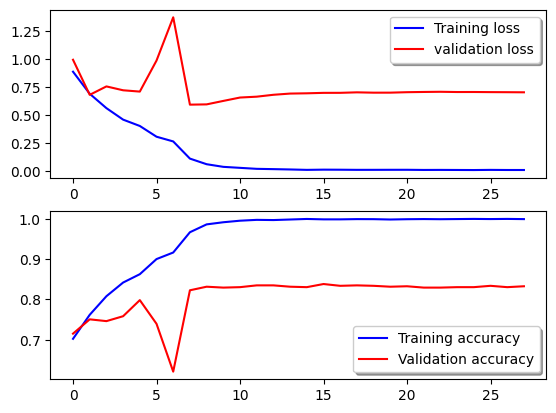

In [23]:
# Plotting the results on Graph
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [24]:
# Concatenating the predictions with final dataframe
data_df  = skin_df
complete_data = pd.concat([data_df, pd.DataFrame(predictions)], axis=1)
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,70.969719,-43.542233,33.533466,17.908745,21.463627,-25.663691,65.395027,57.935486,-30.169704,-11.296326
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,60.132393,-107.659843,-70.799538,160.496033,-39.360081,116.675125,-110.396416,3.000643,-6.710949,90.132843
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,49.561966,-102.441536,-90.157028,177.313766,-2.657188,80.093979,-102.940498,33.272793,-20.371458,97.029503
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,-28.993578,-45.757252,-54.476009,124.525162,18.041355,33.741409,-4.522334,67.133179,17.428333,35.748390
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,16.681677,-72.484306,-92.385643,142.050919,29.270458,48.645618,-88.714897,-33.423431,-21.546375,117.569382


In [25]:
# saving Models

model.save("model.h5")


In [26]:
#Extaracting Features from last 4 layers of the model
model2 = Model(model.input,model.layers[-4].output)
predictions = model2.predict(X)
predictions[0]

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 30ms/step


array([ -9.907978 , -11.468239 , -10.53847  ,  -3.5864356,  18.02972  ,
         9.66886  ,  -1.7303786,   4.5330744,  19.960403 ,  25.329973 ,
        -1.9520154,   2.8111868,  14.14984  ,   5.2691708,  25.819942 ,
        23.56875  ,  -4.0936637, -13.775779 , -12.954501 ,  25.068674 ,
       -12.964365 , -12.082137 ,  -3.656967 ,  -4.82417  , -13.7983265,
        21.218994 ,  11.745412 ,  21.898905 , -12.952776 ,  -7.0223937,
        -8.576946 , -10.151211 ,  -4.7538714,  -8.522185 ,  13.059781 ,
         3.4729447,  -7.7088366,  -3.5778024,   9.242173 ,  18.03258  ,
        22.869019 , -14.407159 ,  16.21408  ,  -7.616851 , -12.9226055,
        -4.2105403,   7.5175757,  10.1021385,   6.078098 , -16.24232  ,
        17.06392  ,  -5.3757877,  -4.516611 ,  -2.0869339,  -9.191705 ,
        -8.545931 ,  -4.596232 ,  -1.0946996, -11.785146 ,  24.426416 ,
        -2.2405376,  -4.6464624,  -6.64441  ,  29.003738 ,  -9.053269 ,
        -3.8938067, -15.009104 ,  18.312954 ,  18.500343 ,   4.5

In [27]:
# Concatenating the predictions with final dataframe
data_df  = skin_df
complete_data = pd.concat([data_df, pd.DataFrame(predictions)], axis=1)
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,19.421801,-8.171981,4.338554,-13.853930,-12.656885,-11.073723,-10.009125,-26.229218,-3.523573,4.434761
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,9.478403,-11.628025,-5.046999,-3.115995,-11.617120,-5.813870,12.354614,-20.611786,-10.894979,19.806944
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,38.036510,-24.763559,-7.699553,-23.954330,-24.920145,-23.427841,-11.766981,-43.997524,-17.286631,18.917902
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,14.004506,-3.646900,0.554174,-15.775434,6.491234,-2.206261,-8.050163,-21.533905,0.154780,-15.023252
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,8.338105,-6.707712,-3.957626,-8.686152,-18.381124,-3.444322,15.371509,-14.333317,-7.489188,28.544306


In [28]:
complete_data.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,...,118,119,120,121,122,123,124,125,126,127
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,19.421801,-8.171981,4.338554,-13.853930,-12.656885,-11.073723,-10.009125,-26.229218,-3.523573,4.434761
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,9.478403,-11.628025,-5.046999,-3.115995,-11.617120,-5.813870,12.354614,-20.611786,-10.894979,19.806944
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,38.036510,-24.763559,-7.699553,-23.954330,-24.920145,-23.427841,-11.766981,-43.997524,-17.286631,18.917902
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,14.004506,-3.646900,0.554174,-15.775434,6.491234,-2.206261,-8.050163,-21.533905,0.154780,-15.023252
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,../input/skin-cancer-mnist-ham10000/ham10000_i...,Benign keratosis-like lesions,2,...,8.338105,-6.707712,-3.957626,-8.686152,-18.381124,-3.444322,15.371509,-14.333317,-7.489188,28.544306


# CNN Predictions

In [29]:
# Making predictions from CNN
complete_data.to_csv('skin_cancer_v2.csv')
preds = model.predict(x_test)
preds

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 139ms/step


array([[3.94538417e-03, 9.20464343e-04, 2.84397006e-01, ...,
        2.36978270e-02, 6.85566843e-01, 5.46445721e-04],
       [6.46214685e-05, 1.18515476e-04, 3.72557738e-03, ...,
        9.73443687e-01, 2.24456210e-02, 1.32659654e-04],
       [3.65484669e-03, 2.03096382e-02, 8.80326796e-03, ...,
        7.26495147e-01, 1.63686518e-02, 2.07623035e-01],
       ...,
       [2.04455409e-06, 2.19987105e-05, 4.14530732e-05, ...,
        9.99384642e-01, 4.53204237e-04, 8.92344906e-05],
       [8.61775596e-03, 1.20051438e-02, 2.43011609e-01, ...,
        5.49526036e-01, 1.75345808e-01, 7.77236978e-03],
       [6.24089080e-05, 2.27455850e-04, 1.16487546e-03, ...,
        9.85454798e-01, 1.28579633e-02, 1.56017602e-04]], dtype=float32)

In [30]:
lst = []
for a in preds:
    lst.append(np.argmax(a))

In [31]:
lst

[5,
 4,
 4,
 4,
 1,
 2,
 4,
 4,
 1,
 0,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 0,
 4,
 4,
 2,
 4,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 2,
 4,
 4,
 4,
 6,
 0,
 4,
 4,
 4,
 4,
 2,
 4,
 5,
 2,
 4,
 2,
 4,
 4,
 4,
 4,
 2,
 4,
 0,
 1,
 4,
 2,
 4,
 4,
 4,
 6,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 1,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 6,
 4,
 4,
 4,
 4,
 2,
 2,
 4,
 2,
 4,
 1,
 1,
 4,
 4,
 1,
 4,
 4,
 0,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 4,
 4,
 0,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 0,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 2,
 2,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 4,
 0,
 0,
 3,
 2,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 0,
 4,
 4,
 3,
 4,
 1,
 4,
 1,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 1,
 4,
 4,
 4,
 4,
 4,
 1,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 4,
 4,
 1,
 6,
 4,
 4,
 2,
 4,
 4,
 4,
 4,
 4,
 2,
 4,
 5,
 4,
 3,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 4,
 4,


# Evaluating CNN Model

In [32]:
confusion_matrix(lst,y_test)

array([[ 17,   2,   0,   0,   0,   0,   0],
       [  5,  42,   6,   0,   9,   4,   1],
       [  5,   4,  68,   0,   7,  11,   0],
       [  1,   0,   0,  11,   0,   0,   0],
       [  3,   2,  28,   1, 649,  46,   0],
       [  2,   0,   7,   0,   5,  49,   0],
       [  0,   1,   1,   0,   1,   1,  13]])

In [33]:
accuracy_score(lst,y_test)

0.8473053892215568

In [34]:
print(classification_report(y_test,lst))

              precision    recall  f1-score   support

           0       0.89      0.52      0.65        33
           1       0.63      0.82      0.71        51
           2       0.72      0.62      0.66       110
           3       0.92      0.92      0.92        12
           4       0.89      0.97      0.93       671
           5       0.78      0.44      0.56       111
           6       0.76      0.93      0.84        14

    accuracy                           0.85      1002
   macro avg       0.80      0.74      0.75      1002
weighted avg       0.84      0.85      0.84      1002



### From the evaluation metrics , it seems like our CNN Model showed accuracy of 84.43%. Let's see if we can improve it....

## GRAD-CAM


In [35]:
print(lesion_type_dict)

{'nv': 'Melanocytic Nevi', 'mel': 'Melanoma', 'bkl': 'Benign keratosis-like lesions ', 'bcc': 'Basal cell carcinoma', 'akiec': 'Actinic keratoses', 'vasc': 'Vascular lesions', 'df': 'Dermatofibroma'}


In [36]:
idx_to_class = {v: k for k, v in lesion_type_dict.items()}
print("Class Index → Class Name mapping:")
for idx in sorted(idx_to_class):
    print(f"{idx} : {idx_to_class[idx]}")


Class Index → Class Name mapping:
Actinic keratoses : akiec
Basal cell carcinoma : bcc
Benign keratosis-like lesions  : bkl
Dermatofibroma : df
Melanocytic Nevi : nv
Melanoma : mel
Vascular lesions : vasc


In [37]:
# Correct label mapping: keys should be class indices in the order used during training
lesion_type_dict = {
    0: 'Actinic keratoses',  # Actinic keratoses
    1: 'Basal cell carcinoma',    # Basal cell carcinoma
    2: 'Benign keratosis-like lesions',    # Benign keratosis-like lesions
    3: 'Dermatofibroma',     # Dermatofibroma
    4: 'Melanocytic nevi (normal)',     # Melanocytic nevi
    5: 'Melanoma',    # Melanoma
    6: 'Vascular lesions',   # Vascular lesions
}


In [38]:
[layer.name for layer in model.layers if 'conv' in layer.name]


['block1_conv1',
 'block1_conv1_bn',
 'block1_conv1_act',
 'block1_conv2',
 'block1_conv2_bn',
 'block1_conv2_act',
 'block2_sepconv1',
 'block2_sepconv1_bn',
 'block2_sepconv2_act',
 'block2_sepconv2',
 'block2_sepconv2_bn',
 'conv2d',
 'block3_sepconv1_act',
 'block3_sepconv1',
 'block3_sepconv1_bn',
 'block3_sepconv2_act',
 'block3_sepconv2',
 'block3_sepconv2_bn',
 'conv2d_1',
 'block4_sepconv1_act',
 'block4_sepconv1',
 'block4_sepconv1_bn',
 'block4_sepconv2_act',
 'block4_sepconv2',
 'block4_sepconv2_bn',
 'conv2d_2',
 'block5_sepconv1_act',
 'block5_sepconv1',
 'block5_sepconv1_bn',
 'block5_sepconv2_act',
 'block5_sepconv2',
 'block5_sepconv2_bn',
 'block5_sepconv3_act',
 'block5_sepconv3',
 'block5_sepconv3_bn',
 'block6_sepconv1_act',
 'block6_sepconv1',
 'block6_sepconv1_bn',
 'block6_sepconv2_act',
 'block6_sepconv2',
 'block6_sepconv2_bn',
 'block6_sepconv3_act',
 'block6_sepconv3',
 'block6_sepconv3_bn',
 'block7_sepconv1_act',
 'block7_sepconv1',
 'block7_sepconv1_bn',


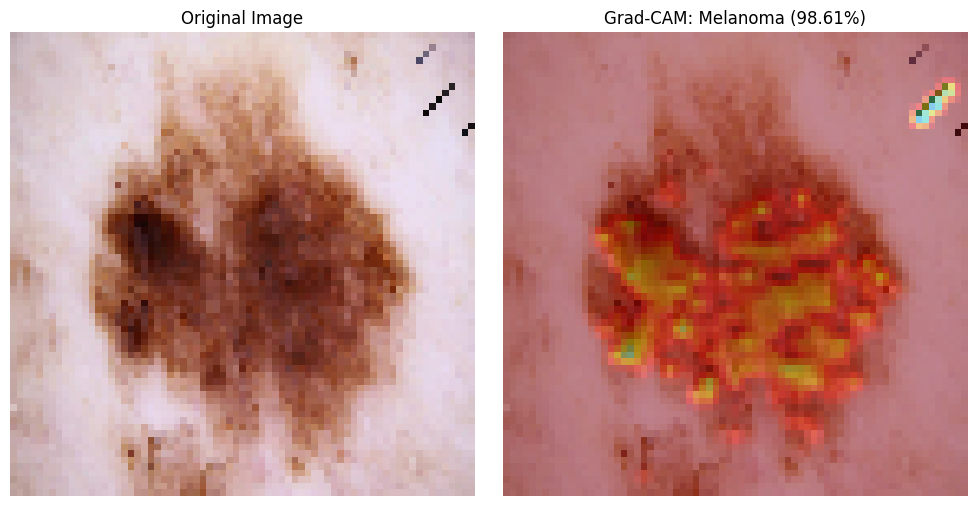

Saved Grad-CAM output to gradcam_output.png
Predicted class: Melanoma with confidence 98.61%


In [43]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os

# Correct label mapping: keys should be class indices in the order used during training
lesion_type_dict = {
    0: 'Actinic keratoses',  # Actinic keratoses
    1: 'Basal cell carcinoma',    # Basal cell carcinoma
    2: 'Benign keratosis-like lesions',    # Benign keratosis-like lesions
    3: 'Dermatofibroma',     # Dermatofibroma
    4: 'Melanocytic nevi (normal)',     # Melanocytic nevi
    5: 'Melanoma',    # Melanoma
    6: 'Vascular lesions',   # Vascular lesions
}


# Load your saved model
from keras.models import load_model
model = load_model("model.h5")

# Define image preprocessing function
def preprocess_image(img_path, size=71):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (size, size))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32) / 255.0
    return np.expand_dims(img, axis=0), img

# Grad-CAM implementation
def make_gradcam_heatmap(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        class_output = predictions[:, class_idx]

    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy(), class_idx.numpy(), predictions.numpy()

# Overlay heatmap
def overlay_gradcam(img, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(heatmap_colored, alpha, img, 1 - alpha, 0)
    return overlayed

# Predict and plot
def gradcam_predict_and_plot(img_path, save_path='gradcam_output.png'):

    img_array, img_rgb = preprocess_image(img_path)
    img_rgb_uint8 = (img_rgb * 255).astype(np.uint8)  # Ensure uint8 type for overlay

    heatmap, pred_class, preds = make_gradcam_heatmap(model, img_array, 'block1_conv1')

    overlayed = overlay_gradcam(img_rgb_uint8, heatmap)
    
    #predicted_label = list(lesion_type_dict.values())[pred_class]
    predicted_label = lesion_type_dict.get(pred_class, "Unknown")

    confidence = preds[0][pred_class] * 100

    # Plot
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(overlayed)
    plt.title(f'Grad-CAM: {predicted_label} ({confidence:.2f}%)')
    plt.axis('off')

    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    print(f"Saved Grad-CAM output to {save_path}")
    return predicted_label, confidence

# Example usage
img_path = '/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_2/ISIC_0029319.jpg'
predicted_label, confidence = gradcam_predict_and_plot(img_path)
print(f"Predicted class: {predicted_label} with confidence {confidence:.2f}%")


In [40]:
pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras
Note: you may need to restart the kernel to use updated packages.


In [41]:
import numpy as np
import tensorflow as tf
import cv2

# Load your model
from keras.models import load_model
model = load_model("model.h5")

# Define class labels
lesion_type_dict = {
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi (normal)',
    5: 'Melanoma',
    6: 'Vascular lesions',
}

# Grad-CAM Functions
def preprocess_frame(frame, size=71):
    frame = cv2.resize(frame, (size, size))
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    norm = rgb.astype(np.float32) / 255.0
    return np.expand_dims(norm, axis=0), rgb

def make_gradcam_heatmap(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_idx = tf.argmax(predictions[0])
        class_output = predictions[:, class_idx]
    grads = tape.gradient(class_output, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap + 1e-8)
    return heatmap.numpy(), class_idx.numpy(), predictions.numpy()

def overlay_gradcam(frame, heatmap, alpha=0.4):
    heatmap = cv2.resize(heatmap, (frame.shape[1], frame.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_colored = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    overlayed = cv2.addWeighted(heatmap_colored, alpha, frame, 1 - alpha, 0)
    return overlayed

# Real-time Grad-CAM with Webcam
def live_gradcam():
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Cannot open webcam")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        input_tensor, rgb = preprocess_frame(frame)
        rgb_uint8 = (rgb).astype(np.uint8)
        
        try:
            heatmap, pred_class, preds = make_gradcam_heatmap(model, input_tensor, 'block1_conv1')
        except Exception as e:
            print(f"Grad-CAM error: {e}")
            continue
        
        overlayed = overlay_gradcam(rgb_uint8, heatmap)
        label = lesion_type_dict.get(pred_class, "Unknown")
        confidence = preds[0][pred_class] * 100

        # Add prediction text
        cv2.putText(overlayed, f"{label}: {confidence:.2f}%", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 2)

        # Show frame
        cv2.imshow("Live Grad-CAM", overlayed)

        # Press 'q' to quit
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Start the live Grad-CAM
live_gradcam()


Cannot open webcam


[ WARN:0@978.710] global cap_v4l.cpp:913 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@978.711] global obsensor_uvc_stream_channel.cpp:158 getStreamChannelGroup Camera index out of range


In [42]:
model.save("skin_model_new")

ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=skin_model_new.